In [1]:
import torch
from time import time
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from zipfile import ZipFile
import numpy as np
from time import time
from torchvision import datasets
from torchvision import transforms
import pandas as pd
import numpy as np
import zipfile
import re
import os
from PIL import Image
from torchvision.io import read_image
from matplotlib import image
from prepare_dataset import MyDataset,subset_generator
from utils import display_some_images,stats_of_image_and_label,MyCuda_Stats,get_output_features_of_model,display_image
from vgg_pretrained import vgg_all_freezed,total_trainable_parameters,full_vgg,vgg_layer_freeze
from Model import Network,new_model
from Transform import Transform
from train_fn import train,validation,image_validation,validation_classes,train_w_transform
from tqdm import tqdm
from sklearn.metrics import classification_report


D:\anaconda\envs\affectnet\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fullvgg=full_vgg()
total_trainable_parameters(fullvgg)
total_trainable_parameters(fullvgg.features)
total_trainable_parameters(vgg_all_freezed())
total_trainable_parameters(vgg_layer_freeze(24))


Total trainable parameters of VGG is 	 138357544

Total trainable parameters of Sequential is 	 14714688

Total trainable parameters of Sequential is 	 0

Total trainable parameters of Sequential is 	 7079424


In [3]:
# DATA LOADER PARAMETERS
batch=16
CUDA_LAUNCH_BLOCKING=1 

In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.ToTensor(),normalize])
target_transform=transforms.Compose([transforms.ToTensor()])

In [5]:
anno_dir=r"./01_data/train_set/annotations"
image_dir=r"./01_data/train_set/images"
train_data=MyDataset(anno_dir,image_dir,transform=transform, target_transform=None)

In [6]:
val_anno_dir=r"./01_data/val_set/annotations"
val_image_dir=r"./01_data/val_set/images"
val_data=MyDataset(val_anno_dir,val_image_dir,transform=transform, target_transform=None)

In [7]:
Subset_train_sampler=subset_generator(train_data,5000)

In [8]:
train_loader=torch.utils.data.DataLoader(train_data,
                                         batch_size=batch,
                                         shuffle=False,
                                         num_workers=4,
                                         pin_memory=True,
                                         sampler=None)
val_loader=torch.utils.data.DataLoader(val_data,
                                       batch_size=batch,
                                       shuffle=False,
                                       num_workers=4,
                                       pin_memory=True,
                                      sampler=None)
val_loader_class=torch.utils.data.DataLoader(val_data,
                                       batch_size=1,
                                       shuffle=False,
                                       num_workers=4,
                                       pin_memory=True,
                                      sampler=None)

In [9]:
print(len(train_loader))
print(len(val_loader))


17979
250


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [11]:
feature_extractor=vgg_layer_freeze(17)
total_trainable_parameters(feature_extractor)



Total trainable parameters of Sequential is 	 12979200


In [12]:

#input_features_for_denselayer=get_output_features_of_model(model=feature_extractor,batch_size=32,dataloader=train_loader)
input_features_for_denselayer=25088


In [13]:
t_image=Transform(input_features_for_denselayer)
model1=new_model(feature_extractor,input_features_for_denselayer).to(device)
model1

new_model(
  (extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

In [14]:
total_trainable_parameters(model1)


Total trainable parameters of new_model is 	 115776520


In [15]:
lr=0.0001
loss1=nn.CrossEntropyLoss()
optimizer=optim.Adam(model1.parameters(),lr)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


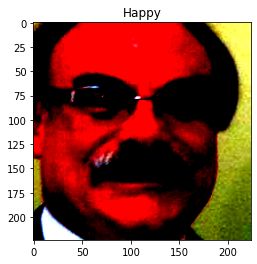

In [16]:
display_image(train_data[0][0],train_data[0][1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


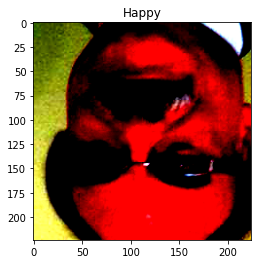

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


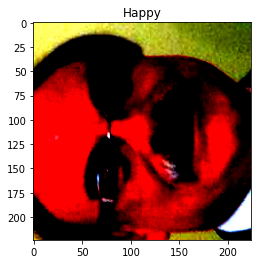

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


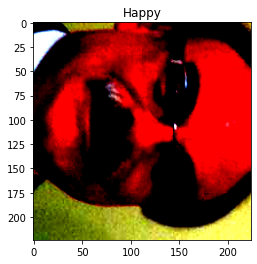

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


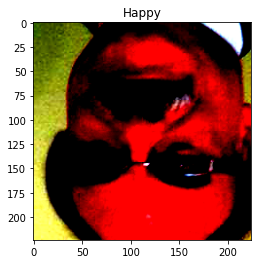

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


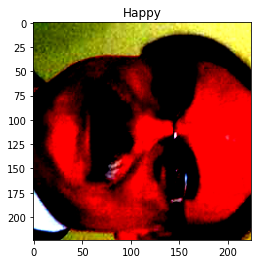

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


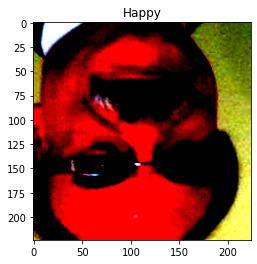

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


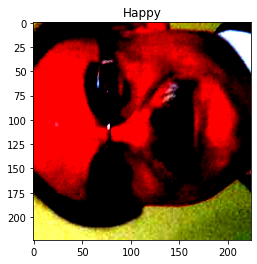

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


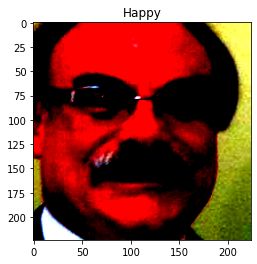

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


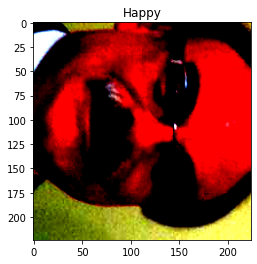

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


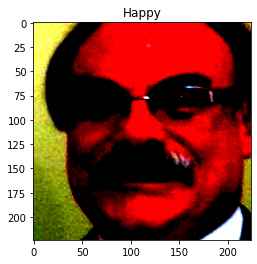

In [17]:
for _ in range(10):
    display_image(t_image.tran(train_data[0][0]),train_data[0][1])

In [ ]:
model1.load_state_dict(torch.load(r"C:\Users\DELL\Desktop\Python\Affect_Net\Affectnet\models\modelrecent.pth"))

In [ ]:
#optimizer.load_state_dict(torch.load(r"C:\Users\DELL\Desktop\Python\Affect_Net\Affectnet\models\optimizer1.pth"))

In [19]:
validation(val_loader,model1,loss1)


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [01:11<00:00,  3.48it/s]

test error-4.361423 
 Accuracy-47.961990%


In [ ]:
val_data[1]

In [20]:
val_loader_class=torch.utils.data.DataLoader(val_data,
                                       batch_size=1,
                                       shuffle=False,
                                       num_workers=4,
                                       pin_memory=True,
                                      sampler=None)

In [ ]:
classes=['Neutral','Happy','Sad','Surprise','Fear','Disgust','Anger','Contempt']


In [22]:
validation_classes(val_loader_class,model1,loss1,0)

100%|█████████████████████████████████████████████████████████████████████████████| 3999/3999 [00:38<00:00, 104.14it/s]

test error-1.056268 
 Accuracy-76.800000%


In [23]:
validation_classes(val_loader_class,model1,loss1,1)

100%|█████████████████████████████████████████████████████████████████████████████| 3999/3999 [00:38<00:00, 104.90it/s]

test error-0.638078 
 Accuracy-89.600000%


In [24]:
validation_classes(val_loader_class,model1,loss1,2)

100%|█████████████████████████████████████████████████████████████████████████████| 3999/3999 [00:39<00:00, 102.45it/s]

test error-2.460785 
 Accuracy-55.000000%


In [25]:
validation_classes(val_loader_class,model1,loss1,3)

100%|█████████████████████████████████████████████████████████████████████████████| 3999/3999 [00:36<00:00, 109.07it/s]

test error-4.931574 
 Accuracy-39.200000%


In [26]:
validation_classes(val_loader_class,model1,loss1,4)

100%|█████████████████████████████████████████████████████████████████████████████| 3999/3999 [00:37<00:00, 106.23it/s]

test error-4.854892 
 Accuracy-38.600000%


In [27]:
validation_classes(val_loader_class,model1,loss1,5)

100%|█████████████████████████████████████████████████████████████████████████████| 3999/3999 [00:36<00:00, 108.95it/s]

test error-8.768421 
 Accuracy-24.800000%


In [28]:
validation_classes(val_loader_class,model1,loss1,6)

100%|█████████████████████████████████████████████████████████████████████████████| 3999/3999 [00:37<00:00, 108.00it/s]

test error-3.339099 
 Accuracy-52.800000%


In [29]:
validation_classes(val_loader_class,model1,loss1,7)

100%|██████████████████████████████████████████████████████████████████████████████| 3999/3999 [00:41<00:00, 96.65it/s]

test error-8.844050 
 Accuracy-6.813627%


In [ ]:
# NO OF EPOCHS IS 5
epochs=50
for epoch in range(epochs):
    print(f'Epoch-{epoch}')
    train_w_transform(train_loader,model1,loss1,optimizer,t_image)
    validation(val_loader,model1,loss1)


In [ ]:
torch.save(model1.state_dict(), r"C:\Users\DELL\Desktop\Python\Affect_Net\Affectnet\models\modelrecent.pth")

In [ ]:
torch.save(optimizer.state_dict(), r"C:\Users\DELL\Desktop\Python\Affect_Net\Affectnet\models\optimizerrecent.pth")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device='cuda', abbreviated=True)